# Expectation Maximization Algorithm

Expectation maximization (EM, Dempster et al. 1977) uses iterative optimization along with a latent variable model to obtain maximum likelihood estimates for models whose parameters are difficult to estimate directly. The algorithm was motivated by missing data imputation. However, the missing values may be deliberately introduced to the problem, as a conceptual ploy that simplifies the obtaining of a solution.

It may not be intuitive how introducing latent (missing) elements to a problem will facilitate its solution, but it works essentially by breaking the optimization into two steps:

1. generating an **expectation** over the missing variable(s) based on current estimates of parameters
2. **maximizing** the log-likelihood from the expectation step, thereby generating updated estimates of parameters

EM is particularly suited to estimating the parameters of *mixture models*, where we do not know from which component each observation is derived.

In general, suppose we have observed quantities $x = x_1,\ldots,x_n$ and unobserved (latent) quantities $z = z_1,\ldots,z_m$ that are derived from some joint model:

$$y = (x,z) \sim P(x,z|\theta)$$

We are interested in obtaining the MLE for the marginal distribution of $X$:

$$x \sim P(x|\theta)$$

However, it is difficult to marginalize over $Z$ and maximize. EM gets around this by iteratively improving an initial estimate $\theta^{(0)}$.

### Example: Mixture of normals

Consider a set of observations, each of which has been drawn from one of two populations:

$$x^{(a)} \sim N(\mu_a, \sigma^2_a)$$
$$x^{(b)} \sim N(\mu_b, \sigma^2_b)$$

except we only observe the values for $x = [x^{(a)}, x^{(b)}]$, not the labels which identify which population they are derived from.

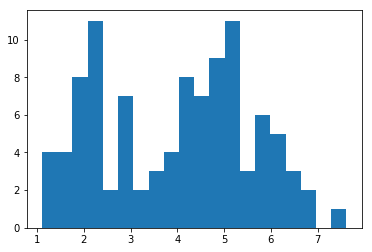

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(77)

# True parameter values
mu_true = np.array([2, 5])
sigma_true = np.array([0.5, 1])
psi_true = .6
n = 100

# Simulate from each distribution according to mixing proportion psi
z = np.random.binomial(1, psi_true, n)
x = np.random.normal(mu_true[z], sigma_true[z])

_ = plt.hist(x, bins=20)

The observed data is then a finite mixture of normal distributions:

$$X = (1 - \psi)X^{(a)} + \psi X^{(b)}$$

This is a generative representation of the data, whereby unobserved labels $z_i$ are generated according to probability $\psi$. We might try to maximize the log likelihood of the joint distribution above, via maximum likelihood:

$$l(\theta) = \sum_i \log\left[(1 - \psi)\phi^{(a)}(x_i) + \psi \phi^{(b)}(x_i)\right] $$

$$\text{where } \theta = \{\psi, \mu^{(a)}, \sigma^{(a)}, \mu^{(b)}, \sigma^{(b)}\}$$

However, this function is very difficult to maximize, and turns out to be bimodal. A simpler approach is to consider the data labels to be unobserved data, and incorporate them into the model. This is generally called a *data augmentation* approach.

The joint distribution of $x$ and $z$ can be factorized into:

$$P(x_i,z_i) = P(x_i \,|\, z_i)P(z_i)$$

It is reasonable to model $z$ as:

$$\{z_i\} \sim \text{Bernoulli}(\psi)$$

where $\psi$ is the probability of membership in group "b" (hence, $1-\psi$ is the probability of group "a" membership). Note that this generalizes to $k$ components in the mixture, where $z_i \sim \text{Multinomial}(\psi)$ with $\psi$ of dimension $k-1$.

Clearly, the distribution of $x$ conditional on $z$ is:

$$(x_i | z_i = j) \sim N(\mu_j, \sigma_j)$$

If we knew the $\{z_i\}$, then we could simply use MLE to obtain estimates for the paramters of the model. However, we do not know the labels, which makes this a form of **unsupervised learning**.

### Algorithm

Continuing with the mixture of normals model as our example, we can apply the EM algorithm to estimate $\theta = \{\mu, \sigma, \psi\}$.

> **Initiazlize** $\theta_0 = \{\mu_0, \sigma_0, \psi_0\}$
> 
> **Repeat until convergence:**
> 
> - **E-step**: guess the values of $\{z_i\}$
> 
>     Compute probabilities of group membership: $w_{ij} = P(z_i = j | x_i, \theta)$ for each group $j=1,\ldots,k$. This is done via Bayes' formula:
>     
>     $$P(z_i = j | x_i) = \frac{P(x_i | z_i=j) P(z_i=j)}{\sum_{l=1}^k P(x_i | z_i=l) P(z_i=l)}$$
>     
>     $\theta$ has been dropped for notational convenience.
>     
> - **M-step**: update estimates of parameters $\theta$
> 
>     $$\begin{aligned}\psi_j &= \frac{1}{m} \sum_i w_{ij} \\
       \mu_j &= \frac{\sum_i w_{ij} x_i}{\sum_i w_{ij}} \\
       \sigma_j &= \frac{\sum_i w_{ij}(x_i - \mu_j)^2}{\sum_i w_{ij}}
     \end{aligned}$$

### General formulation

Recall [**Jensen's inequality**](http://mathworld.wolfram.com/JensensInequality.html):

> Let $f$ be a convex function (*i.e.* $f^{\prime\prime} \ge 0$) of a random variable X. Then:
> $f(E[X]) \le E[f(X)]$

And when $f$ is *strictly* convex, then:

$$E[f(X)] = f(E[X]) \iff X = E[X]$$

with probability 1.

Consider again the joint density $P(x,z|\theta)$, where only $x$ is observed. We want to be able to maximize:

$$\begin{aligned}
l(x \,|\, \theta) &= \sum_i \log P(x_i \,|\, \theta) \\
&= \sum_i \log \sum_{z_i} P(x_i, z_i \,|\, \theta)
\end{aligned}$$

however, evaluating this is difficult when the $\{z_i\}$ are unobserved.

The EM algorithm iteratively calculates *lower bounds on the likelihood* for the current values of the parameters, then *maximizes the lower bound* to update the parameters.

Since $z_i$ is a random variable, perhaps we can construct its density $Q_i$ and use it to marginalize the joint likelihood:

$$\sum_i \log \sum_{z_i} P(x_i, z_i \,|\, \theta) = \sum_i \log \sum_{z_i} Q_i(z_i) \frac{P(x_i, z_i \,|\, \theta)}{Q_i(z_i)}$$

This turns the inner summation into an expectation.

$$\sum_i \log \sum_{z_i} Q_i(z_i) \frac{P(x_i, z_i \,|\, \theta)}{Q_i(z_i)} = \sum_i \log E_{Q_i} \left[ \frac{P(x_i, z_i \,|\, \theta)}{Q_i(z_i)} \right]$$

Now, if we apply Jensen's inequality (note that the logarithm is a *concave* function, so the inequality is reversed):

$$\begin{aligned}
\sum_i \log E_{Q_i} \left[ \frac{P(x_i, z_i \,|\, \theta)}{Q_i(z_i)} \right] &\ge \sum_i  E_{Q_i} \log \left[ \frac{P(x_i, z_i \,|\, \theta)}{Q_i(z_i)} \right] \\
&= \sum_i \sum_{z_i}  Q_i(z_i) \log \left[ \frac{P(x_i, z_i \,|\, \theta)}{Q_i(z_i)} \right]
\end{aligned}$$

We need to ensure that the equality condition holds true, which we can do by choosing $Q_i$ appropriately. Specifically, we want a $Q_i$ such that:

$$\frac{P(x_i, z_i \,|\, \theta)}{Q_i(z_i)} = C$$

which implies:

$$Q_i(z_i) \propto P(x_i, z_i \,|\, \theta)$$

Since $Q_i$ is a density,

$$\begin{aligned}
Q_i(z_i) &= \frac{P(x_i, z_i \,|\, \theta)}{\sum_{z_i} P(x_i, z_i \,|\, \theta)} \\
&= \frac{P(x_i, z_i \,|\, \theta)}{P(x_i \,|\, \theta)} \\
&= P(z_i \,|\, x_i, \theta)
\end{aligned}$$

Returning to our normal mixture example:

For the **E-step** we need to identify $Q_i(z_i)$

$$Q_i(z_i) = P(z_i \,|\, x_i, \mu, \sigma, \psi)$$

Via Bayes' formula:

$$P(z_i=j \,|\, x_i) = \frac{P(x_i \,|\, z_i=j)P(z_i=j)}{\sum_l P(x_i \,|\, z_i=l)P(z_i=l)}$$

where $P(x_i \,|\, z_i=l)$ is just the $j$th Normal distribution of the mixture, and $P(z_i=l)$ is a multinomial probability.

This gives us:

$$P(z_i=1 \,|\, x_i) = \frac{\psi N(\mu_b, \sigma_b^2)}{\psi N(\mu_a, \sigma_a^2) + (1-\psi) N(\mu_b, \sigma_b^2)}$$

(recall that we are encoding `a=0` and `b=1`)

This can be implemented easily in Python:

In [2]:
from scipy.stats.distributions import norm

def e_step(x, mu, sigma, psi):
    a = psi * norm.pdf(x, mu[0], sigma[0])
    b = (1. - psi) * norm.pdf(x, mu[1], sigma[1])
    return b / (a + b)

In [3]:
e_step(0.4, mu_true, sigma_true, psi_true)

0.001415844457163535

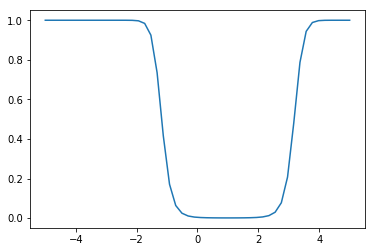

In [4]:
x_range = np.linspace(-5,5)
plt.plot(x_range, e_step(x_range, mu_true, sigma_true, psi_true))

For the **M-step** we need to maximize

$$\begin{aligned}\text{argmax}_{\mu,\Sigma, \psi}  \sum_i \sum_{z_i}  Q_i(z_i) \log \left[ \frac{P(x_i, z_i \,|\, \theta)}{Q_i(z_i)} \right] \\
= \sum_i \sum_{z_i} w_{ij} \log \left[\frac{1}{\sqrt{2 \pi} \, |\Sigma_j|^{1/2} \, w_{ij}} e^{-\frac{1}{2} (x_i - \mu_j) \Sigma^{-1} (x_i - \mu_j))} \psi_j\right]
\end{aligned}$$

which we can show is

$$\begin{aligned}\psi_j &= \frac{1}{m} \sum_i w_{ij} \\
\mu_j &= \frac{\sum_i w_{ij} x_i}{\sum_i w_{ij}} \\
\sigma_j &= \frac{\sum_i w_{ij}(x_i - \mu_j)^2}{\sum_i w_{ij}}
\end{aligned}$$

This can be coded into Python as `m_step`:

In [5]:
def m_step(x, w):
    psi = np.mean(w) 
    
    mu = [np.sum((1-w) * x)/np.sum(1-w), np.sum(w * x)/np.sum(w)]
    
    sigma = [np.sqrt(np.sum((1-w) * (x - mu[0])**2)/np.sum(1-w)), 
             np.sqrt(np.sum(w * (x - mu[1])**2)/np.sum(w))]
    
    return mu, sigma, psi

In [6]:
# Initialize values
mu = np.random.normal(size=2)
sigma = np.random.uniform(0, 10, 2)
psi = np.random.random()

# Stopping criterion
crit = 1e-4

# Convergence flag
converged = False

# Loop until converged
while not converged:
    
    # E-step
    w = e_step(x, mu, sigma, psi)
    # M-step
    mu_new, sigma_new, psi_new = m_step(x, w)
    
    # Check convergence
    converged = ((np.abs(psi_new - psi) < crit) 
                 & np.all(np.abs((np.array(mu_new) - np.array(mu)) < crit))
                 & np.all(np.abs((np.array(sigma_new) - np.array(sigma)) < crit)))
    mu, sigma, psi = mu_new, sigma_new, psi_new
                    
    print('A: N({0:.4f}, {1:.4f})\nB: N({2:.4f}, {3:.4f})\npsi: {4:.4f}'.format(
                        mu_new[0], sigma_new[0], mu_new[1], sigma_new[1], psi_new))

A: N(4.0119, 1.6035)
B: N(3.9248, 1.6039)
psi: 0.4521
A: N(4.0203, 1.6027)
B: N(3.9331, 1.6044)
psi: 0.5478
A: N(4.0120, 1.6028)
B: N(3.9248, 1.6048)
psi: 0.4522
A: N(4.0204, 1.6023)
B: N(3.9331, 1.6048)
psi: 0.5477
A: N(4.0121, 1.6026)
B: N(3.9247, 1.6049)
psi: 0.4524
A: N(4.0205, 1.6023)
B: N(3.9330, 1.6048)
psi: 0.5476
A: N(4.0122, 1.6026)
B: N(3.9246, 1.6050)
psi: 0.4525
A: N(4.0206, 1.6022)
B: N(3.9329, 1.6048)
psi: 0.5474
A: N(4.0123, 1.6026)
B: N(3.9245, 1.6050)
psi: 0.4527
A: N(4.0207, 1.6022)
B: N(3.9327, 1.6048)
psi: 0.5473
A: N(4.0124, 1.6025)
B: N(3.9244, 1.6050)
psi: 0.4528
A: N(4.0208, 1.6022)
B: N(3.9326, 1.6048)
psi: 0.5471
A: N(4.0125, 1.6025)
B: N(3.9243, 1.6050)
psi: 0.4529
A: N(4.0209, 1.6022)
B: N(3.9325, 1.6048)
psi: 0.5470
A: N(4.0126, 1.6025)
B: N(3.9242, 1.6050)
psi: 0.4531
A: N(4.0210, 1.6022)
B: N(3.9324, 1.6048)
psi: 0.5468
A: N(4.0127, 1.6025)
B: N(3.9241, 1.6050)
psi: 0.4532
A: N(4.0211, 1.6022)
B: N(3.9323, 1.6048)
psi: 0.5467
A: N(4.0129, 1.6025)
B: N(3.

psi: 0.5189
A: N(4.0425, 1.6006)
B: N(3.8971, 1.6047)
psi: 0.4812
A: N(4.0481, 1.6004)
B: N(3.9025, 1.6047)
psi: 0.5187
A: N(4.0428, 1.6006)
B: N(3.8969, 1.6047)
psi: 0.4814
A: N(4.0483, 1.6004)
B: N(3.9022, 1.6047)
psi: 0.5186
A: N(4.0430, 1.6006)
B: N(3.8967, 1.6047)
psi: 0.4815
A: N(4.0485, 1.6003)
B: N(3.9020, 1.6047)
psi: 0.5184
A: N(4.0433, 1.6006)
B: N(3.8964, 1.6047)
psi: 0.4817
A: N(4.0488, 1.6003)
B: N(3.9017, 1.6047)
psi: 0.5183
A: N(4.0436, 1.6006)
B: N(3.8962, 1.6047)
psi: 0.4818
A: N(4.0490, 1.6003)
B: N(3.9014, 1.6047)
psi: 0.5181
A: N(4.0438, 1.6005)
B: N(3.8960, 1.6047)
psi: 0.4820
A: N(4.0492, 1.6003)
B: N(3.9012, 1.6046)
psi: 0.5179
A: N(4.0441, 1.6005)
B: N(3.8957, 1.6047)
psi: 0.4821
A: N(4.0495, 1.6003)
B: N(3.9009, 1.6046)
psi: 0.5178
A: N(4.0443, 1.6005)
B: N(3.8955, 1.6047)
psi: 0.4823
A: N(4.0497, 1.6002)
B: N(3.9006, 1.6046)
psi: 0.5176
A: N(4.0446, 1.6005)
B: N(3.8952, 1.6047)
psi: 0.4824
A: N(4.0500, 1.6002)
B: N(3.9004, 1.6046)
psi: 0.5175
A: N(4.0449, 1.6

A: N(4.3110, 1.5568)
B: N(3.6342, 1.5794)
psi: 0.5000
A: N(4.3168, 1.5553)
B: N(3.6284, 1.5784)
psi: 0.5001
A: N(4.3229, 1.5537)
B: N(3.6222, 1.5773)
psi: 0.5000
A: N(4.3294, 1.5520)
B: N(3.6159, 1.5761)
psi: 0.5001
A: N(4.3361, 1.5501)
B: N(3.6091, 1.5748)
psi: 0.5000
A: N(4.3432, 1.5481)
B: N(3.6020, 1.5735)
psi: 0.5001
A: N(4.3508, 1.5460)
B: N(3.5944, 1.5720)
psi: 0.5001
A: N(4.3588, 1.5437)
B: N(3.5865, 1.5704)
psi: 0.5001
A: N(4.3672, 1.5411)
B: N(3.5780, 1.5687)
psi: 0.5001
A: N(4.3762, 1.5384)
B: N(3.5690, 1.5668)
psi: 0.5001
A: N(4.3858, 1.5354)
B: N(3.5594, 1.5647)
psi: 0.5001
A: N(4.3961, 1.5321)
B: N(3.5492, 1.5624)
psi: 0.5001
A: N(4.4070, 1.5285)
B: N(3.5382, 1.5599)
psi: 0.5001
A: N(4.4189, 1.5246)
B: N(3.5265, 1.5572)
psi: 0.5001
A: N(4.4316, 1.5202)
B: N(3.5137, 1.5541)
psi: 0.5001
A: N(4.4454, 1.5152)
B: N(3.5000, 1.5506)
psi: 0.5002
A: N(4.4604, 1.5097)
B: N(3.4850, 1.5467)
psi: 0.5002
A: N(4.4767, 1.5035)
B: N(3.4687, 1.5423)
psi: 0.5002
A: N(4.4947, 1.4964)
B: N(3.

### Example: Zero-inflated data

Code the EM algorithm to estimate the paramters of a zero-inflated Poisson (ZIP) model.

$$\begin{eqnarray}
f(x \mid \theta, \psi) &\sim& \left\{ \begin{array}{l}
            Poisson(\theta) \text{ w.p. } \psi \\
            0 \text{ w.p. } 1-\psi
            \end{array} \right. \\
&=& \left\{ \begin{array}{l}
            \psi \frac{e^{-\theta}\theta^x}{x!}, \text{if } x=1,2,3,\ldots \\
            (1-\psi) + \psi e^{-\theta}, \text{if } x = 0
            \end{array} \right.
\end{eqnarray}$$

(array([ 65.,  14.,   0.,  15.,   0.,   4.,   0.,   1.,   1.]),
 array([ 0.        ,  0.55555556,  1.11111111,  1.66666667,  2.22222222,
         2.77777778,  3.33333333,  3.88888889,  4.44444444,  5.        ]),
 <a list of 9 Patch objects>)

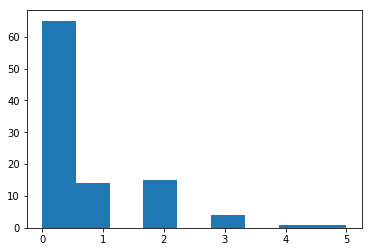

In [7]:
import numpy as np

# True parameter values
mu_true = 1.5
psi_true = .4
n = 100

# Simulate some data
data = np.array([np.random.poisson(mu_true)*(np.random.random()<psi_true) for i in range(n)])
plt.hist(data, bins=9)

In [8]:
from scipy.stats.distributions import poisson

In [9]:
def e_step(x, mu, psi):
    
    a = (1-psi) * (x==0)
    b = psi * poisson.pmf(x, mu)
    
    return b / (a+b)
    

In [10]:
def m_step(x, w):
    
    psi = np.mean(w)
    
    mu = np.sum(w*x)/np.sum(w)
    
    return mu, psi

In [11]:
def run_em(mu0=1, psi0=0.5, x=data):
    
    # Initialize values
    mu = mu0
    psi = psi0

    # Stopping criterion
    crit = 1e-5

    # Convergence flag
    converged = False

    # Loop until converged
    while not converged:

        # E-step
        w = e_step(x, mu, psi)
        # M-step
        mu_new, psi_new = m_step(x, w)

        # Check convergence
        converged = ((np.abs(psi_new - psi) < crit) 
                     & np.all(np.abs((np.array(mu_new) - np.array(mu)) < crit)))
        mu, psi = mu_new, psi_new

    return mu, psi


In [12]:
run_em()

(1.3984619324892422, 0.46479634868788261)

### Example: Peppered moth genotype frequencies

Peppered moths (*Biston betularia*) is an example of microevoloution occuring at human time scales. The coloring of the moth is determined by a single gene that is comprised of three alleles:

* T
* I (dominant to T)
* C (dominant to I, T)

thus, the genotype TT corresponds to the *typica* phenotype, which results in a light-colored wing pattern; CC, CI and CT results in the dark *carbonaria* phenytype; while IT and II encode an intermediate *insularia* phenotype.

Prior to the industrial revolution, the lighter typical and insularia were common, but were eventually replaced by the darker typica phenotype. It is thought that differential predation resulted from the lighter phenotypes being conspicuous against tree bark darkened by pollution from the industrial use of coal; darker carbonaria strains were camoflauged against the darker trees, which offered protection from predation. When air quality standards were improved, the relative abundance of the lighter phenotypes increased to pre-industrial levels.

![Gypsy moths](images/moth.jpg)

Absent genetic methods for ascertaining the genotypes underlying each individual observed phenotype, we require statistical methods for estimating these frequencies. If we represent the three **allele freuqencies** by the variables $p_C$, $p_I$ and $p_T$, then the genotypes and corresponding frequencies are:

* CC = $p_C^2$
* CI = $2p_C p_I$
* CT = $2p_C p_T$
* II = $p_I^2$
* IT = $2p_I p_T$
* TT = $p_T^2$

The genotype frequencies are *latent variables*. If we were able to count alleles, rather than phenotypes, estimating these frquencies would be straightforward.

We are able to observe counts of phenotypes, $x_C$, $x_I$ and $x_T$, but not counts of genotypes, $X_{CC}, X_{CI}, X_{CT}, X_{II}, X_{IT}, X_{TT}$, except in the case of $X_{TT} = x_T$, since there is only one genotype that can produce this phenotype.

If we had complete data, the latent allele frequencies could be estimated using a **multinomial model**:

$$\begin{eqnarray}f(x \mid n, \pi) &=& \frac{n!}{\prod_{i=1}^k x_i!} \prod_{i=1}^k \pi_i^{x_i} \\
&=& \frac{n!}{x_{CC}! x_{CI}! x_{CT}! x_{II}! x_{IT}! x_{TT}!} (p_C^2)^{x_{CC}} (2p_C p_I)^{x_{CI}} (2p_C p_T)^{x_{CT}} (p_I^2)^{x_{II}} (2p_I p_T)^{x_{IT}} (p_T^2)^{x_{TT}} \end{eqnarray}$$

We can use the EM algorithm to estimate the latent variables conditional on the data that we do observe. We first need to construct $Q(z) = P(z|x)$ so that this expectation can be calculated. For each unobserved genotype count, we need to estimate the proportion of the observed phenotype count that is contributed by that genotype. For example, in the case of the homozygous *carbonaria*:

$$E[X_{CC}| x_{C}, x_{T}, x_{I}, \mathbf{p}^{(t)}] = x_{(CC)}^{(t)} = \frac{x_C (p_C^{(t)})^2}{(p_C^{(t)})^2 + 2p_C^{(t)} p_I^{(t)} + 2p_C^{(t)} p_T^{(t)}}$$

Similarly, for genotype CI:

$$E[X_{CI}| x_{C}, x_{T}, x_{I}, \mathbf{p}^{(t)}] = x_{(CI)}^{(t)} = \frac{2 x_C p_C^{(t)} p_I^{(t)}}{(p_C^{(t)})^2 + 2p_C^{(t)} p_I^{(t)} + 2p_C^{(t)} p_T^{(t)}}$$

and so on.

### Exercise: E-step

Code the expectation step for the latent genotype counts.

In [13]:
# Number in each phenotype
x_C = 85  
x_I = 196 
x_T = 341

N = x_C + x_I + x_T

In [14]:
# Write your answer here

def e_step2(xc, )

To update the values of the allele frequencies, we need to maximize the multinomial (log) likelihood.

Since the combinatorial term does not involve $\mathbf{p}$, we can write:

$$\begin{eqnarray}
Q(\mathbf{p}) &\propto& x_{(CC)}^{(t)} \log[(p_C^2)^{(t)}] + x_{(CI)}^{(t)} \log[2p_C^{(t)}p_I^{(t)}] \\
&+& x_{(CT)}^{(t)} \log[2p_C^{(t)}p_T^{(t)}] + x_{(II)}^{(t)} \log[(p_I^2)^{(t)}] \\
&+& x_{(IT)}^{(t)} \log[2p_I^{(t)}p_T^{(t)}] + x_{(TT)}^{(t)} \log[(p_T^2)^{(t)}]
\end{eqnarray}$$

Since $p_T = 1 - p_I + p_C$, we only need to worry about maximizing two functions:

$$\frac{dQ}{dp_C} = \frac{2x_{(CC)}^{(t)} + x_{(CI)}^{(t)} + x_{(CT)}^{(t)}}{p_C} - \frac{2x_{(TT)}^{(t)} + x_{(CT)}^{(t)} + x_{(IT)}^{(t)}}{1 - p_C - p_I}$$

$$\frac{dQ}{dp_I} = \frac{2x_{(II)}^{(t)} + x_{(CI)}^{(t)} + x_{(IT)}^{(t)}}{p_I} - \frac{2x_{(TT)}^{(t)} + x_{(CT)}^{(t)} + x_{(IT)}^{(t)}}{1 - p_C - p_I}$$

If we set these equal to zero and solve for the $p$'s, we complete the M step.

$$p_C^{(t+1)} = \frac{2x_{(CC)}^{(t)} + x_{(CI)}^{(t)} + x_{(CT)}^{(t)}}{2N}$$

$$p_I^{(t+1)} = \frac{2x_{(II)}^{(t)} + x_{(CI)}^{(t)} + x_{(IT)}^{(t)}}{2N}$$

$$p_T^{(t+1)} = \frac{2x_{(TT)}^{(t)} + x_{(CT)}^{(t)} + x_{(IT)}^{(t)}}{2N}$$

So, the update involves setting each $p$ equal to the phenotype frequencies that correspond to the latent genotype count at that step.

### Exercise: M-step

Code a function for calculating the M-step.

In [15]:
# Write your answer here

### Exercise: Estimate allele frequencies

Combine the E-step and M-step to estimate the latent allele frequencies using EM.

In [16]:
# Write your answer here

## Convergence

Each time we perform the maximization step, the likelihood of the observed data increases. Note that:

$$P(x,z) = P(z \,|\, x)P(x)$$

which implies:

$$\begin{eqnarray}
E[\log P(x)| x, \theta^{(t)}] &=& E[\log P(x,z)|\theta^{(t)})] - E[\log P(z \,|\, x)| x, \theta^{(t)}] \\
&=& Q(\theta | \theta^{(t)}) - H(\theta | \theta^{(t)})
\end{eqnarray}$$

where $H(\theta | \theta^{(t)}) = E[\log P(z \,|\, x)| x, \theta^{(t)}]$.

The second term is maximized with respect to $\theta$ when $\theta^{(t)} = \theta$:

$$\begin{eqnarray}
H(\theta^{(t)} | \theta^{(t)}) - H(\theta | \theta^{(t)}) &=& E[\log P(z \,|\, x, \theta^{(t)}) - \log P(z \,|\, x, \theta) | x, \theta^{(t)}] \\
&=& \int -\log \left[ \frac{\log P(z \,|\, x, \theta)}{\log P(z \,|\, x, \theta^{(t)})} \right] \log P(z \,|\, x, \theta^{(t)}) dz \\
&\ge& -\log \int \log P(z \,|\, x, \theta) dz = 0
\end{eqnarray}$$

where the inequality is due to Jensen's inequality.

So, any $\theta \ne \theta^{(t)}$ makes $H(\theta | \theta^{(t)})$ smaller than $H(\theta^{(t)} | \theta^{(t)})$.

If we choose a $\theta^{(t+1)}$ to maximimze $Q(\theta | \theta^{(t)})$ then we have:

$$\log P(x |\theta^{(t+1)}) - \log P(x |\theta^{(t)}) \ge 0$$

because $Q$ increases and $H$ decreases.

The EM algorithm guaranteees that $P(x \,|\, \theta^{(t+1)}) \ge  P(x \,|\,  \theta^{(t)})$, however there is no guarantee that we will obtain the true MLE (due to multimodality).

### Order of convergence

The global rate of convergence for EM is:

$$\rho = \lim_{t \rightarrow \infty} \frac{||\theta^{(t+1)} - \hat{\theta}||}{||\theta^{(t)} - \hat{\theta}||}$$

EM has approximately linear convergence, provided the observed information is positive definite. The realized rate of convergence slows as the proportion of missing data increases.

Though the performance of EM is very slow relative to other optimization methods, it is easy to implement and stable, and is therefore widely used. It works best for likelihoods of the [exponential family of distributions](https://en.wikipedia.org/wiki/Exponential_family).

### Exercise: Monitoring convergence

Modify your EM code above to track the convergence of the algorithm as it is run.

In [17]:
# Write your answer here

# References

- A. P. Dempster; N. M. Laird; D. B. Rubin. 1977. [Maximum Likelihood from Incomplete Data via the EM Algorithm](http://web.mit.edu/6.435/www/Dempster77.pdf) Journal of the Royal Statistical Society. Series B (Methodological), Vol. 39, No. 1. (1977), pp. 1-38.
- [Python for Signal Processing](http://python-for-signal-processing.blogspot.com/2012/11/expectation-maximization-expectation.html)
- [Stanford University's Machine Learning (Coursera)](https://www.coursera.org/course/ml)